<a href="https://www.kaggle.com/code/victortrigo/cnn-pneumonia?scriptVersionId=100228509" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Deep Learning for Pneumonia Diagnosis

Author: Victor Trigo

Pneumonia is an infection of the lung tissue, commonly found in children and adults over 65 years of age. The diagnosis of pneumonia primarily requires a chest x-ray and physical examinations. Improving our diagnostic skills is of great value to medicine. The dataset is a set of images of chest X-rays.

Next, will be development a Convolutional Neural Network to classify chest X-rays in 'pneumonia' or 'normal'.

## Libraries

In [1]:
import tensorflow as tf                                                                                              # Backend of Keras
from tensorflow.keras import models, optimizers, regularizers                                                        # Model's components
from tensorflow.keras.models import Sequential, load_model                                                           #
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization    # Model's layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator                                                  # Data Augmentation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping                                                # Checkpoint and Stop 

import matplotlib.pyplot as plt                                                                                      # Plots
import numpy as np                                                                                                   # Maths
import pandas as pd                                                                                                  # Data Frames

import cv2                                                                                                           # directory management tool
import os                                                                                                            #


import warnings                                                                                                      # Warning
warnings.filterwarnings("ignore")

## ETL

We will create a function called 'get_traning_data' that uses directory management tools ('os' and 'cv' libraries) to load the dataset.

The images of chest X-rays is loaded with 150 x 150 px dimension.

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')

OpenCV(4.5.4-dev) /tmp/pip-req-build-0culq997/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4-dev) /tmp/pip-req-build-0culq997/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



The validation dataset of Kaggle have only 16 images.  Will be build a new validation dataset from trainig dataset.

For this will use a Bernoulli distribution to separate training dataset and validation datasets

In [4]:
l = np.random.binomial(1, 0.1, 5216)       # array of 0s and 1s in proportion 0.9 and 0.1 

x_train = []
y_train = []

x_val = []
y_val = []

for i in range(1,5216):
    if l[i] == 0:                         # if i = 0 add image to Train
            x_train.append(train[i][0])
            y_train.append(train[i][1])
    else:                                 # if i = 1 add image to Validation
            x_val.append(train[i][0])
            y_val.append(train[i][1])

Test dataset will be separate in feature and label.

In [5]:
x_test = []
y_test = []

for feature, label in test:
    x_test.append(feature)   # Image
    y_test.append(label)     # 'pneumonia' or 'normal'

Estandarizamos y ejecutamos un reshape a las imágenes.

In [6]:
# Dividir entre 255 para que los números existan en el intervalo (0,1)
# s
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [7]:
# en resumen el reshape es: (para x_train) 4648 imagenes de 150 por 150 y 1 canal de color

x_train = x_train.reshape(x_train.shape[0], img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(x_val.shape[0], img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(x_test.shape[0], img_size, img_size, 1)
y_test = np.array(y_test)

In [8]:
# Cambiar tipo de variable de las categorias

y_train = tf.keras.utils.to_categorical(
    y_train, num_classes=2, dtype='float32'
)

y_val = tf.keras.utils.to_categorical(
    y_val, num_classes=2, dtype='float32'
)

y_test = tf.keras.utils.to_categorical(
    y_test, num_classes=2, dtype='float32'
)

In [9]:
# Para comprobar los cambios
print('train data image: ', x_train.shape)
print('test data image: ', x_test.shape)
print('val data image: ', x_val.shape)

train data image:  (4677, 150, 150, 1)
test data image:  (624, 150, 150, 1)
val data image:  (538, 150, 150, 1)


In [10]:
# Para comprobar los cambios
print('train data image: ', y_train.shape)
print('test data image: ', y_test.shape)
print('val data image: ', y_val.shape)

train data image:  (4677, 2)
test data image:  (624, 2)
val data image:  (538, 2)


## Data Viz

Podemos ver ejemplo de como se ve una radiografia ya cargada a una dimencion de 150 x 150 px

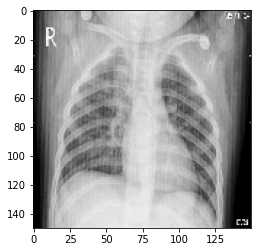

In [11]:
# ej. de radiografia
plt.imshow(x_train[0], cmap='gray')

## Model

El modelo comienza con Data Augmentation, donde las se generan mas imagenes a partir de las existentes, para así disminuir el desbalanceo en los datos.

In [12]:
# Aumento del dataset para no sesgar por desbalance
datagen = ImageDataGenerator(rotation_range=15,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True
)

In [13]:
# Guardado del mejor modelo (en funcion de val_accuracy) en medio del entrenamiento
checkpoint = ModelCheckpoint('mejor_modelo.hdf5', 
                             verbose=1, 
                             save_best_only=True, 
                             monitor='val_accuracy'
)

In [14]:
# Tamaño de filtro y tamaño de tasa de aprendizaje
base_filtros = 32
w_regularizers = 1e-4

In [15]:
# Arquitectura neuronal
model = Sequential()

model.add(Conv2D(base_filtros,   (3,3), padding='same', strides=(1,1), kernel_regularizer=regularizers.l2(w_regularizers), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4,4)))


model.add(Conv2D(2*base_filtros, (3,3), padding='same', strides=(1,1), kernel_regularizer=regularizers.l2(w_regularizers)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 150, 150, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 37, 37, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 37, 64)        2

2022-07-07 05:53:37.434699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 05:53:37.549332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 05:53:37.550117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 05:53:37.551298: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
# Compilacion del modelo con función de perdida categorical_crossentropy y optimizador adam
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy']
)

In [17]:
# ajuste en 150 epocas utilizando 40 imagenes por epoca y guardando el mejor modelo. Ademas utilizando funcion datagen definida anteriormente.
hist = model.fit(datagen.flow(x_train, y_train),
                 callbacks=[checkpoint],
                 steps_per_epoch=40,
                 epochs=150,
                 verbose=2,
                 validation_data=(datagen.flow(x_val, y_val))
)

2022-07-07 05:53:40.951731: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-07-07 05:53:42.730011: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


40/40 - 11s - loss: 0.9294 - accuracy: 0.7917 - val_loss: 0.5276 - val_accuracy: 0.7398

Epoch 00001: val_accuracy improved from -inf to 0.73978, saving model to mejor_modelo.hdf5
Epoch 2/150
40/40 - 3s - loss: 0.6116 - accuracy: 0.8571 - val_loss: 0.5595 - val_accuracy: 0.7398

Epoch 00002: val_accuracy did not improve from 0.73978
Epoch 3/150
40/40 - 3s - loss: 0.5284 - accuracy: 0.8750 - val_loss: 0.5986 - val_accuracy: 0.7398

Epoch 00003: val_accuracy did not improve from 0.73978
Epoch 4/150
40/40 - 3s - loss: 0.4288 - accuracy: 0.8923 - val_loss: 0.3886 - val_accuracy: 0.7732

Epoch 00004: val_accuracy improved from 0.73978 to 0.77323, saving model to mejor_modelo.hdf5
Epoch 5/150
40/40 - 3s - loss: 0.5232 - accuracy: 0.8828 - val_loss: 0.5852 - val_accuracy: 0.7416

Epoch 00005: val_accuracy did not improve from 0.77323
Epoch 6/150
40/40 - 3s - loss: 0.4358 - accuracy: 0.8969 - val_loss: 0.3789 - val_accuracy: 0.8011

Epoch 00006: val_accuracy improved from 0.77323 to 0.80112, s

Este grafico muestra la evolucion del entrenamiento

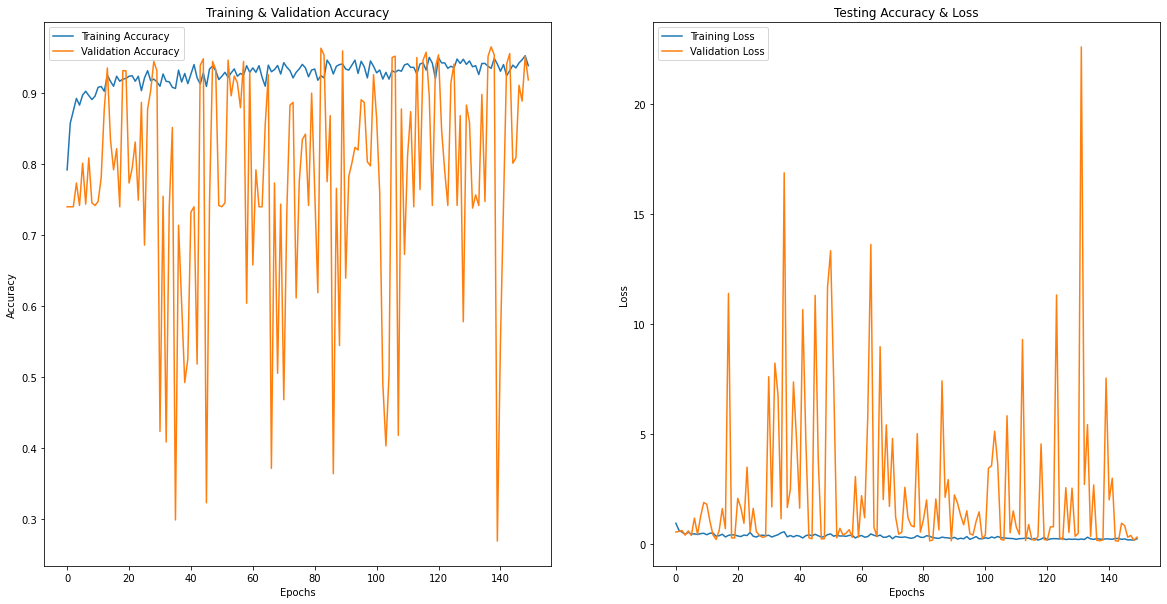

In [18]:
# Grafica de entrenamiento
epochs = [i for i in range(150)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs, hist.history['accuracy'],     label='Training Accuracy')
ax[0].plot(epochs, hist.history['val_accuracy'], label= 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, hist.history['loss'],     label = 'Training Loss')
ax[1].plot(epochs, hist.history['val_loss'], label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

Podemos ver ademas que el modelo guardado en checkpoint tiene mejor performance que el modelo resultante al final del entrenamiento.

In [19]:
# Evaluacion del modelo entrenado
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 7ms/step - loss: 0.5874 - accuracy: 0.8429
Loss of the model is -  0.5874338150024414
20/20 [==============================] - 0s 6ms/step - loss: 0.5874 - accuracy: 0.8429
Accuracy of the model is -  84.29487347602844 %


In [20]:
# Evaluacion del mejor modelo en entrenamiento
model2 = load_model('./mejor_modelo.hdf5')
print("Loss of the model is - " , model2.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model2.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 5ms/step - loss: 0.4890 - accuracy: 0.8590
Loss of the model is -  0.4890430271625519
20/20 [==============================] - 0s 5ms/step - loss: 0.4890 - accuracy: 0.8590
Accuracy of the model is -  85.89743375778198 %


Una vision mas clara tenemos de esto al examinar la matriz de confusión

In [21]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


(624,)
(624,)


<Figure size 432x288 with 0 Axes>

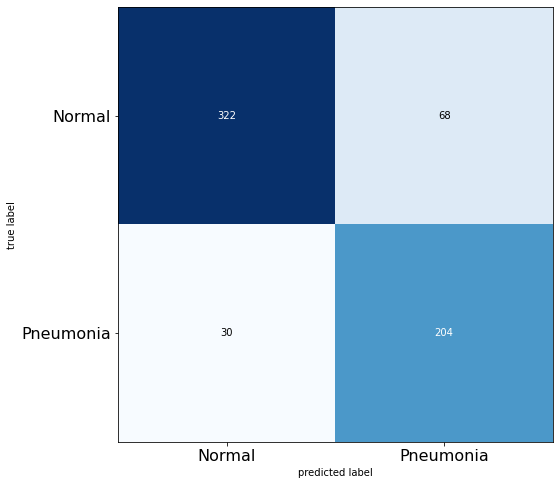

In [22]:
# Matriz de confusion para modelo entrenado
preds = model.predict(x_test, batch_size=16)
preds = np.argmax(preds, axis=-1)

orig_test_labels = np.argmax(y_test, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

(624,)
(624,)


<Figure size 432x288 with 0 Axes>

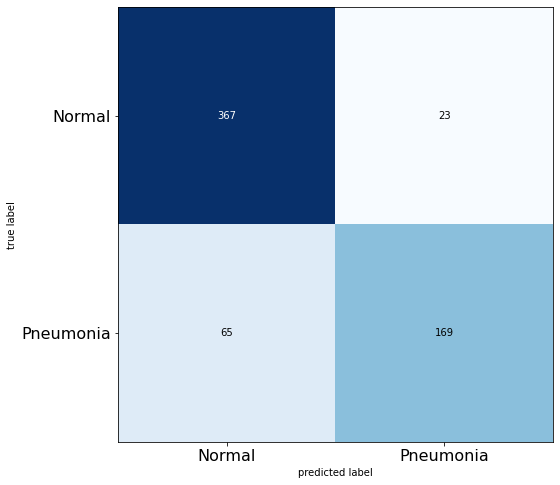

In [23]:
# Matriz de confusion para el mejor modelo guardado
preds = model2.predict(x_test, batch_size=16)
preds = np.argmax(preds, axis=-1)

orig_test_labels = np.argmax(y_test, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

Aqui podemos obtener las siguientes métricas:

- accuracy: 0.873
- recall: 0.959
- especificidad: 0.731
- presición: 0.856
- valor predicho negativo: 0.914

La especificidad es el valor mas bajo obtenido, lo que indica los muchos errores que comete el algoritmo al intentar clasificar la neumonía como tal.